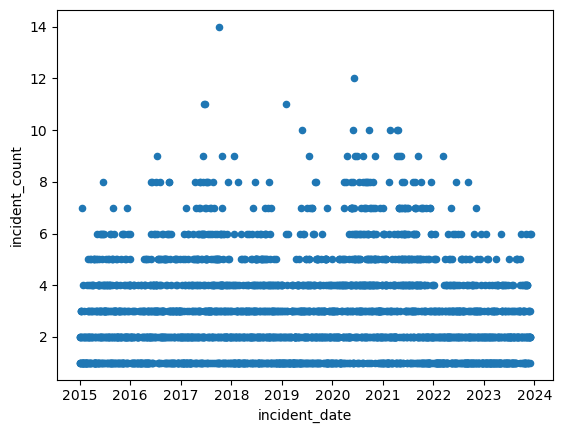

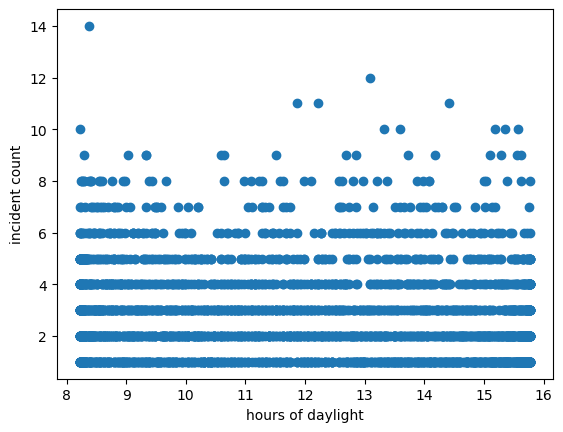

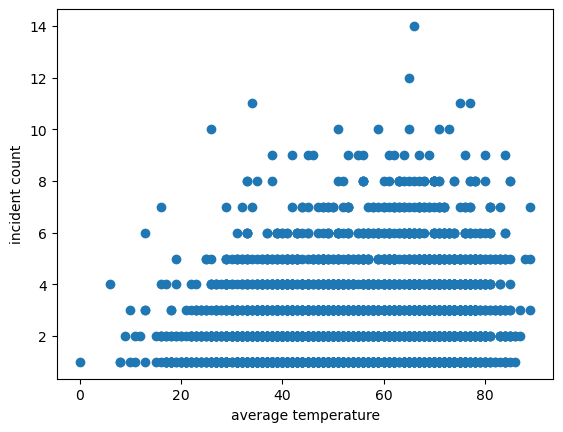

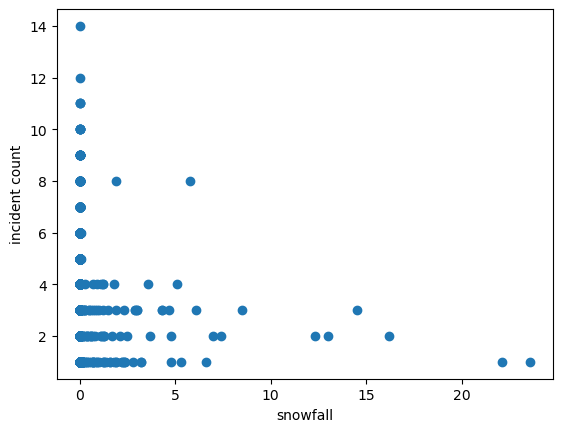

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%run 'ShotsFired_EDA copy.ipynb'


In [2]:
# data lookin good
shots_daily.head()

,incident_date,district,ballistics_evidence,incident_count,PRCP,SNOW,TAVG,hours_of_daylight
0,2015-01-01,C11A15,False,2,0.00,0.0,26,12.587640
1,2015-01-02,B3E13,True,2,0.00,0.0,34,12.646087
2,2015-01-03,B2,False,1,0.62,1.4,28,12.704440
3,2015-01-04,B2B2,True,2,0.57,0.0,38,12.762693
4,2015-01-05,C6,False,1,0.00,0.0,40,12.820834


In [3]:
shots_daily['incident_count'].unique()

array([ 2,  1,  3,  7,  4,  5,  6,  8,  9, 11, 14, 10, 12])

In [4]:
# let's create a X and y

X = shots_daily[['PRCP', 'SNOW', 'TAVG', 'hours_of_daylight']]
y = shots_daily['incident_count']

print(X.shape)
print(y.shape)


(2806, 4)
(2806,)


In [5]:
# let's split our data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# let's scale our data

# from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# ss.fit(X_train)
# X_train = ss.transform(X_train)
# X_test = ss.transform(X_test)

In [6]:
# let's run a linear regression using keras

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

model = keras.Sequential([
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(14, activation='softmax')
])


In [7]:
y_train = tf.one_hot(y_train, depth=14)
y_train

<tf.Tensor: shape=(2104, 14), dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [8]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [9]:
callback_val_loss = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
)

callback_val_accuracy = keras.callbacks.EarlyStopping(
    monitor="vall_accuracy",
    patience=6,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0000
)

In [10]:
batch_size = 128
epochs = 100

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callback_val_loss, reduce_lr],
                    validation_split=0.1
                    )

Epoch 1/100


15/15 [==============================] - 0s 6ms/step - loss: 2.5436 - accuracy: 0.1669 - val_loss: 2.3231 - val_accuracy: 0.1991 - lr: 0.0100
Epoch 2/100
15/15 [==============================] - 0s 1ms/step - loss: 2.0361 - accuracy: 0.2509 - val_loss: 2.2132 - val_accuracy: 0.2038 - lr: 0.0100
Epoch 3/100
15/15 [==============================] - 0s 1ms/step - loss: 1.8727 - accuracy: 0.2451 - val_loss: 2.1725 - val_accuracy: 0.1991 - lr: 0.0100
Epoch 4/100
15/15 [==============================] - 0s 1ms/step - loss: 1.8322 - accuracy: 0.2583 - val_loss: 2.1455 - val_accuracy: 0.2417 - lr: 0.0100
Epoch 5/100
15/15 [==============================] - 0s 1ms/step - loss: 1.8280 - accuracy: 0.2557 - val_loss: 2.1724 - val_accuracy: 0.2227 - lr: 0.0100
Epoch 6/100
15/15 [==============================] - 0s 1ms/step - loss: 1.8163 - accuracy: 0.2588 - val_loss: 2.1091 - val_accuracy: 0.2038 - lr: 0.0100
Epoch 7/100
15/15 [==============================] - 0s 1ms/step - loss: 1.8123 - accura